# Introduction
Naturally, in business, we invest in customers to generate revenue and be profitable. These actions make some customers super valuable in terms of lifetime value but there are always some customers who pull down the profitability. We need to identify these behavior patterns, segment customers and act accordingly.

Calculating Lifetime Value is done using the RFM concept:
- R(ecency): how recently did customer purchase?
- F(requency): how often do customer purchase?
- M(onetary Value): how much do they spend (each time on average)?

RFM analysis is based on the 80/20 rule. The rule states that '80% of the business comes from 20% of the clients'. It helps compartmentalize customers into clusters to identify those who are more likely to respond to promotions, and also to upsell or cross-sell. We can then use machine learning to help us make future CLV predictions to provide a direction for the company to go into.

Our dataset contains sales record from 1st Dec 2010 to 9 Dec 2011.

### Imports


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Exploratory Data Analysis
Let's start by importing our dataset.

In [2]:
df = pd.read_csv('./dataset/online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

We have 8 features and 541 909 sales records. Let's take a look at the statistics of our important numerical columns (Quantity and UnitPrice) as well as data types.

In [4]:
df.describe()
df.dtypes

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Mean quantity is 9 with a massive standard deviation of 218 units. This means that there are lots of outliers. We can see that the maximum is 80995 which might have an effect on this. Similarly, the unit price is \\$4.6 ith a standard deviation of \\$96.7 with a maximum price of \\$38 970. However, we see that there are minimums below 0 for both quantity and unit price. These could be due to returned items. Let's remove these first.

In [5]:
cols = ['Quantity','UnitPrice']

for col in cols:
    df = df[df[col]>0]

We can look at the kurtosis and skewness of these fields to have a idea of how normal the distribution is, skewness being the symmetry and kurtosis showing the extreme values in the tails. Ideally, we want these units to be as close to 0 as possible.

In [6]:
for col in cols:
    print('Skewness of '+col+' : ' +str(df[col].skew()))
    print('Kurtosis of '+col+' : ' +str(df[col].kurtosis())+'\n')
    

Skewness of Quantity : 471.7277163313442
Kurtosis of Quantity : 236462.34282634672

Skewness of UnitPrice : 206.08755495006463
Kurtosis of UnitPrice : 62483.14271510476



Let's remove the outliers by taking only the data in the 99.5% percentile. 

In [7]:
for col in cols:
    df = df[df[col]<df[col].quantile(0.995)].reset_index(drop=True)
    print('Skewness of '+col+' : ' +str(df[col].skew()))
    print('Kurtosis of '+col+' : ' +str(df[col].kurtosis())+'\n')

Skewness of Quantity : 4.833400449886601
Kurtosis of Quantity : 30.38491200815992

Skewness of UnitPrice : 2.249681399843632
Kurtosis of UnitPrice : 6.26993547122412



Let's look at any missing data that we have.

In [8]:
df.isnull().sum()/len(df)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.812346
Country         0.000000
dtype: float64

In [9]:
df[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1417,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1418,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1419,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1420,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1421,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524000,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom
524001,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
524002,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
524003,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom


We have no customer ID for these transactions. It is impossible to impute the unique IDs to perfrom a Customer Lifetime Value analysis, therefore we will remove them completely.

In [10]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

As noticed, our dataset date range is from 1st Dec 2010 to 9 Dec 2011. Let's only look at the sales for a year, so until 1 Dec 2011.

In [11]:
df = df[df['InvoiceDate'] < '2011-12-01']

An important metric that needs to be calculated is the actual sale figure in dollars by multiplying the unit price with the quantity.

In [12]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

Let's look at the sales done per customer per invoice.

In [13]:
# Converting series to datetime object
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

orders_df = df.groupby(['CustomerID','InvoiceNo']).agg({'Sales':sum, 'InvoiceDate':max})
orders_df.head(10)

Sales         InvoiceDate
CustomerID InvoiceNo                             
12347.0    537626      711.79 2010-12-07 14:57:00
           542237      475.39 2011-01-26 14:30:00
           549222      386.65 2011-04-07 10:43:00
           556201      382.52 2011-06-09 13:01:00
           562032      584.91 2011-08-02 08:48:00
           573511     1294.32 2011-10-31 12:25:00
12348.0    539318      652.80 2010-12-16 19:09:00
           541998      187.44 2011-01-25 10:42:00
           548955      327.00 2011-04-05 10:47:00
           568172      270.00 2011-09-25 13:13:00

In [14]:
# Custom aggregate functions
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max()-x.min()).days

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max()-x.min()).days/x.count()

# Naming the columns after creation
groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

# Creation of summary dataframe
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

# Rename our columns by combinng it with the top row
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

summary_df.head(10)

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12347.0,382.52,1294.32,3835.58,639.263333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,187.44,652.80,1437.24,359.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1417.60,1417.60,1417.60,1417.600000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,294.40,294.40,294.40,294.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
12352.0,104.35,296.50,1385.74,197.962857,7.0,2011-02-16 12:33:00,2011-11-03 14:37:00,260,37.142857
12353.0,89.00,89.00,89.00,89.000000,1.0,2011-05-19 17:47:00,2011-05-19 17:47:00,0,0.000000
12354.0,1079.40,1079.40,1079.40,1079.400000,1.0,2011-04-21 13:11:00,2011-04-21 13:11:00,0,0.000000
12355.0,459.40,459.40,459.40,459.400000,1.0,2011-05-09 13:49:00,2011-05-09 13:49:00,0,0.000000
12356.0,58.35,2271.62,2811.43,937.143333,3.0,2011-01-18 09:50:00,2011-11-17 08:40:00,302,100.666667


With the above table, we can look count how many customers made certain number of purchases. However, we are interested in return customer for CLV calculation so we need to remove customers that only had one purchse ie. invoice date purchasde duration greater than 0.

Text(0, 0.5, 'count')

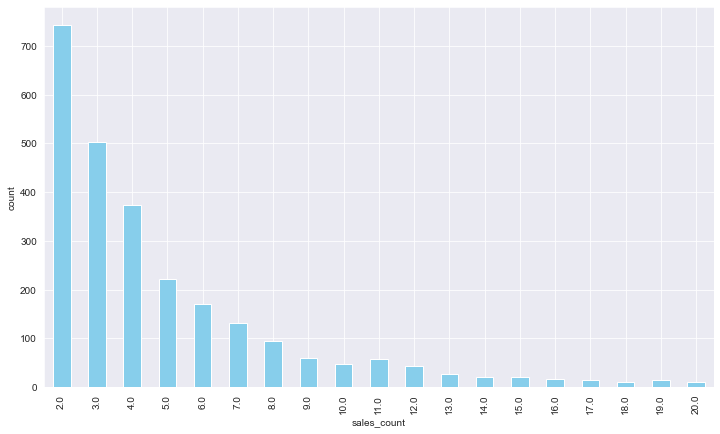

In [15]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(kind='bar', color='skyblue',figsize=(12,7), grid=True)

ax.set_ylabel('count')

The majority of our customers make 2-5 (all above 200 customers), while less than 200 customers tend to purchase 6-20 items (for each number in that range). It follows a decaying curve relationship.

Let's look at the histogram of the average times between sales.

Text(0.5, 0, 'avg. number of days between purchases')

Text(0, 0.5, 'count')

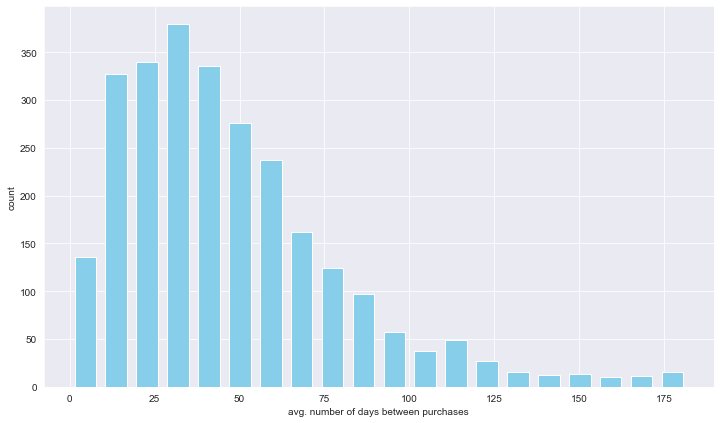

In [16]:
ax = summary_df['invoicedate_purchase_frequency'].hist(bins=20, color='skyblue', rwidth=0.7, figsize=(12,7))

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

Average number of days between purchases is around a month. The distribution is right skewed normal distribution, and this is because there are more customers making regular purchases while infrequent purchasers make the least purchases and therefore would have a higher time to their next purchase.

## CLV for  3 Months
Let's calculate the CLV for a 3 months period. Let's create a statistics summary from our previous orders_df dataframe.

In [17]:
clv_freq = '3M'

# Groupby customer ID now, and group all invoices for 3 month cycles.
# Aggregate on sum, mean and counts
data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({
    'Sales': [sum, groupby_mean, groupby_count],})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12347.0,2010-12-31,711.79,711.790,1.0
1,12347.0,2011-03-31,475.39,475.390,1.0
2,12347.0,2011-06-30,769.17,384.585,2.0
3,12347.0,2011-09-30,584.91,584.910,1.0
4,12347.0,2011-12-31,1294.32,1294.320,1.0


Let's create our recency data column, ie. how recently did a customer make their last purchase.

In [18]:
# Adding Recency 'M'

# Get the M
date_month_map = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True))}

# Create our M Column
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12347.0,2010-12-31,711.79,711.790,1.0,M_5
1,12347.0,2011-03-31,475.39,475.390,1.0,M_4
2,12347.0,2011-06-30,769.17,384.585,2.0,M_3
3,12347.0,2011-09-30,584.91,584.910,1.0,M_2
4,12347.0,2011-12-31,1294.32,1294.320,1.0,M_1


We can then expand  our columns to represent each month.

In [21]:
# Create our Features DF
features_df = pd.pivot_table(data_df.loc[data_df['M'] != 'M_1'], values=['sales_sum', 'sales_avg', 'sales_count'], columns='M', index='CustomerID')

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12347.0,584.91,384.585,475.3900,711.79,1.0,2.0,1.0,1.0,584.91,769.17,475.39,711.79
12348.0,270.00,327.000,187.4400,652.80,1.0,1.0,1.0,1.0,270.00,327.00,187.44,652.80
12350.0,NaN,NaN,294.4000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,294.40,NaN
12352.0,256.25,NaN,160.3775,NaN,2.0,NaN,4.0,NaN,512.50,NaN,641.51,NaN
12353.0,NaN,89.000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,89.00,NaN,NaN


Now, for the CLV table!

In [29]:
# CLV
response_df = data_df.loc[data_df['M'] == 'M_1', ['CustomerID', 'sales_sum']]

response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df.sort_values(by='CLV_3M',ascending=False).head(10)

,CustomerID,CLV_3M
3604,14646.0,41952.80
4025,14911.0,38864.96
2729,14096.0,37712.30
8850,18102.0,35464.51
2719,14088.0,24983.92
7948,17511.0,15969.75
114,12415.0,14263.21
7871,17450.0,12796.35
8484,17841.0,12314.79
712,12748.0,10994.77


We now have a list of clients with their respective CLVs. We can then use linear regression to make future predictions on new customers.

## Linear Regression
Let's merge our features dataset with our CLV dataset for machine learning use.

In [30]:
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

sample_set_df = sample_set_df.fillna(0)
sample_set_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
4.0,584.91,384.585,475.3900,711.79,1.0,2.0,1.0,1.0,584.91,769.17,475.39,711.79,12347.0,1294.32
NaN,270.00,327.000,187.4400,652.80,1.0,1.0,1.0,1.0,270.00,327.00,187.44,652.80,12348.0,0.00
NaN,0.00,0.000,294.4000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,294.40,0.00,12350.0,0.00
13.0,256.25,0.000,160.3775,0.00,2.0,0.0,4.0,0.0,512.50,0.00,641.51,0.00,12352.0,231.73
NaN,0.00,89.000,0.0000,0.00,0.0,1.0,0.0,0.0,0.00,89.00,0.00,0.00,12353.0,0.00


Let's apply linear regression!

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Our Target Variable
target_var = 'CLV_'+clv_freq

# Our Features
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

# Split data in Train and Test
x_train, x_test, y_train, y_test = train_test_split(sample_set_df[all_features], sample_set_df[target_var], test_size=0.3)

# Fit Model
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

# Run our input data into our model predictors
train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

# Assess performance Training Data
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error

print(r2_score(y_true=y_train, y_pred=train_preds))
print(median_absolute_error(y_true=y_train, y_pred=train_preds))
print(np.sqrt(mean_squared_error(y_true=y_train, y_pred=train_preds)))

LinearRegression()

0.6541035720908375
215.60961789805248
999.1283332355063


Our model  has an R^2 score of 68%, meaning it fits 68% of the observed data.